<img src="images/header.png">

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Линейные модели (практика)</center></h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

In [2]:
try:
    from ipywidgets import interact, IntSlider, fixed
except ImportError:
    print u'Так надо'

# Линейная регрессия

## Пример: Стоимость автомобиля

Загрузите [тренировочные данные](http://bit.ly/1gIQs6C) и [тестовые данные](http://bit.ly/IYPHrK) - уже знакомые нам данные по автомобилям.

In [3]:
df_train = pd.read_csv('http://bit.ly/1gIQs6C')
df_test = pd.read_csv('http://bit.ly/IYPHrK')

In [4]:
df_train.head()

,price,mileage,year,trim,engine,transmission
0,14995,67697,2006,ex,4 Cyl,Manual
1,11988,73738,2006,ex,4 Cyl,Manual
2,11999,80313,2006,lx,4 Cyl,Automatic
3,12995,86096,2006,lx,4 Cyl,Automatic
4,11333,79607,2006,lx,4 Cyl,Automatic


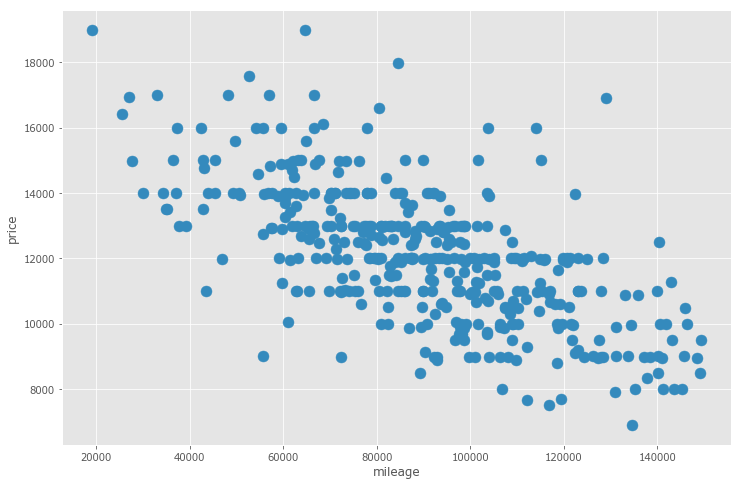

In [5]:
df_train.plot(x='mileage', y='price', kind='scatter', s=120)

Кажется, что между стоимостью и пробегом зависимость линейная - давайте ее найдем!

In [6]:
X_train = df_train.mileage.values.reshape(-1, 1)
y_train = df_train.price.values

In [7]:
from sklearn.linear_model import LinearRegression

Обучим модель

In [8]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
print 'Модель:\nprice = %.2f + (%.2f)*mileage' % (model.intercept_, model.coef_[0])

Модель:
price = 16762.02 + (-0.05)*mileage


Нарисуйте предсказание модели (прямую) вместе с данными на плоскости. Здесь можно либо явно взять уравнение прямой и посчитать значения в каждой точке, либо через predict.

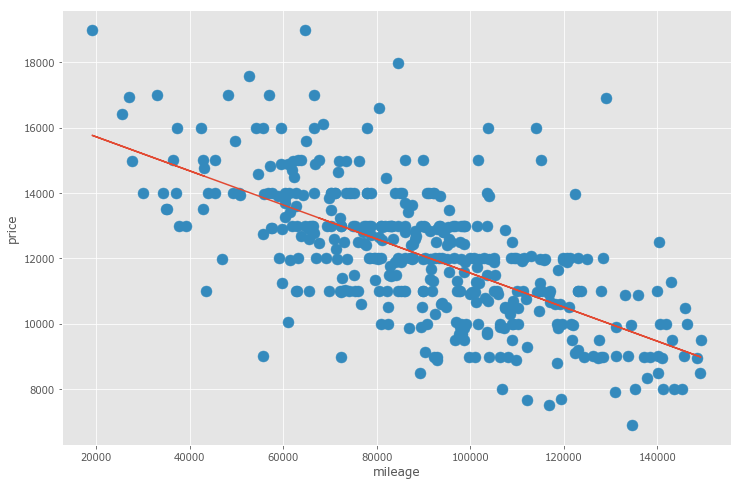

In [11]:
df_train.plot(x='mileage', y='price', kind='scatter', s=120)

y_hat = model.predict(X_train)

plt.plot(X_train, y_hat)

### Меры качества

In [12]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Можно посчитать простые варианты агрегирования остатков, например:

* $\frac{1}{n} \sum_i |\hat{y}^{(i)}-y^{(i)}|$ - средняя абсолютная ошибка
* $\frac{1}{n} \sum_i (\hat{y}^{(i)}-y^{(i)})^2$ - средняя квадратичная ошибка

In [13]:
y_hat = model.predict(X_train)

In [14]:
print('Средняя абсолютная ошибка %.2f' % mean_absolute_error(y_train, y_hat))
print('Средняя квадратичная ошибка %.2f' % mean_squared_error(y_train, y_hat))

Средняя абсолютная ошибка 1182.21
Средняя квадратичная ошибка 2412292.55


Можно рассмотреть более сложную меру: коэффициент детерминации $R^2$:

* $TSS = \sum_i (y^{(i)}-\bar{y})^2$ - общая сумма квадратов (total sum of squares)
* $RSS = \sum_i (\hat{y}^{(i)}-y^{(i)})^2$ - сумма квадратов остатков (residual sum of squares)
* $ESS = \sum_i (\hat{y}^{(i)}-\bar{y})^2$ - объясненная сумма квадратов (explained sum of squares)

Для простоты будем считать, что
$$TSS = ESS + RSS$$

Тогда Коэффициент детерминации $R^2=1-\frac{RSS}{TSS}$

Рассчитайте его для нашей модели


## Преобразование переменных

### Нормализация

Переход к близким или единым шкалам улучшает сходимость градиентного спуска, уменьшает риск переполнения разрядности чисел, однако приходится жертвовать прямой интерпретируемостью..

Нормализацию обычно проделывают для вещественных признаков.

Нормализация z-score:
1. Вычитаем среднее: $x - \bar{x}$
2. Делим на стандартное отклонение: $\frac{x - \bar{x}}{std(x)}$

Можно проделать вручную, можно с помошью метода ниже

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = LinearRegression(fit_intercept=True)
model.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
print('Модель:\nprice = %.2f + (%.2f)*mileage`' % (model.intercept_, model.coef_[0]))

Модель:
price = 12084.24 + (-1351.67)*mileage`


## Как обучать линейную регрессию?
Попробуем разобраться без всяких `.predict()` и `.fit()`

### Рассмотрим случай с одним признаком и свободным членом

$X$ - признаковое описание наблюдений,<br\> $y$ - прогнозируемая величина

Пусть задана функция ошибки (функция потерь) $L(\cdot)$. <br\>
Нам надо построить такой функционал $f(X)$, который будет выдавать значение наиболее близкие к $y$, иначе говоря: $$L\left(f(X) - y\right) \rightarrow\min $$

Определим функцию потерь, как сумму квадратов разности выдаваемого ответа функционала и реального значения: 
$$ L(\cdot) = \frac{1}{2n}\sum_{i=1}^n(f(x^{(i)}) - y^{(i)})^2$$

Так как среди всего множества моделей мы выбрали линейную регрессию, то $$f(X) = \beta_0 + \beta_1x_1$$
Подставляем это выражение в $L(\cdot)$ и находим $\beta_0$,
$\beta_1$!

$$ L(\beta_0,\beta_1) = \frac{1}{2n}\sum^{n}_{i=1}(f(x^{(i)})  - y^{(i)})^2 = \frac{1}{2n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)})^2  \rightarrow \min\limits_{\beta_0, \beta_1} $$

Изобразим функцию потерь на трехмерном графике в зависимости от $\beta_0$ и $\beta_1$ для задачи с автомобилем

In [18]:
X_train[:10]

array([[-0.84965517],
       [-0.61665239],
       [-0.3630531 ],
       [-0.14000144],
       [-0.39028369],
       [ 0.279257  ],
       [ 1.4048907 ],
       [ 1.13894894],
       [-0.62533069],
       [-1.50720052]])

In [19]:
# для удобства добавим столбец из "1" в матрицу с признаком "пробег"
X_model = np.c_[np.ones(X_train.shape), X_train]
X_model.shape

(417, 2)

In [20]:
X_model[:10]

array([[ 1.        , -0.84965517],
       [ 1.        , -0.61665239],
       [ 1.        , -0.3630531 ],
       [ 1.        , -0.14000144],
       [ 1.        , -0.39028369],
       [ 1.        ,  0.279257  ],
       [ 1.        ,  1.4048907 ],
       [ 1.        ,  1.13894894],
       [ 1.        , -0.62533069],
       [ 1.        , -1.50720052]])

In [21]:
from mpl_toolkits import mplot3d

Text(0,0.5,u'beta_1')

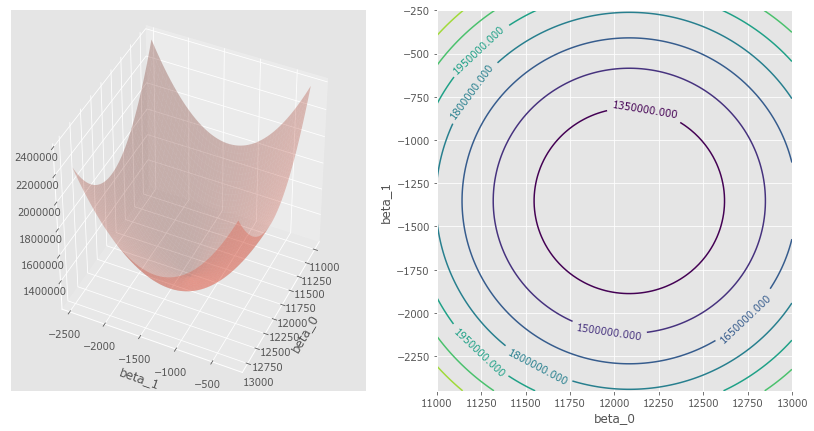

In [22]:
beta0 = np.linspace(11000 , 13000, 100)
beta1 = np.linspace(-2450, -250, 100)

B0, B1= np.meshgrid(beta0, beta1)

B_all = np.c_[B0.reshape(-1,1), B1.reshape(-1,1)].T

L = X_model.dot(B_all) - y_train.reshape(-1,1)
L = L ** 2
L = L.mean(axis=0)/2
L = L.reshape(B0.shape)


fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(40, 25)
ax.plot_surface(B0, B1, L, alpha=0.3,)
ax.set_xlabel('beta_0')
ax.set_ylabel('beta_1')

ax = fig.add_subplot(1, 2, 2)
contour = ax.contour(B0, B1, L)
plt.clabel(contour, inline=1, fontsize=10)
ax.set_xlabel('beta_0')
ax.set_ylabel('beta_1')

### Градиентный спуск

Градиентый спуск - это итеративный метод оптимизации функции. Он заключается в постепенном перемещении к точке экспетмума в направлении антиградиента этой функции в точке.

Посчитаем, чему равен градиент функции потерь $L(\beta_0, \beta_1):$
$$ \frac{\partial L}{\partial \beta_0} = \frac{1}{n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)})$$
$$ \frac{\partial L}{\partial \beta_1} = \frac{1}{n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)})x_1^{(i)}$$

Иногда проще это записать в виде матриц:
$$ \frac{\partial L}{\partial \beta} = X^\top(X\beta - y)$$

Метод градиентного спуска заключается в итеративном и **одновременном(!!!)** обновлении значений $\beta$ в направлении, противоположному градиенту:
$$ \beta := \beta -  \frac{\alpha}{n} \frac{\partial L}{\partial \beta}$$


Теперь к шагам алгоритма:

* Задаем случайное начальное значение для $\beta$
* Пока не будет достигнуто правило останова:
    * Считаем ошибку и значение функции потерь
    * Считаем градиент
    * Обновляем коэффициенты

In [23]:
def gradient_descent(X, y, iters, alpha):
    
    costs = []
    betas = []
    
    n = y.shape[0] 
    Beta = np.random.rand(X.shape[1])
    for i in range(iters):
        y_hat = X.dot(Beta)
        
        # считаем ошибку и значение функции потерь
        resid = (y_hat - y) # ошибки
        cost = (resid**2).sum()
        
        # считаем градиент
        grad = X.T.dot(resid)

        # обновляем коэффициенты
        Beta = Beta - alpha/n * grad
        
        if (i % 10) == 0:
            betas.append(Beta)
            costs.append(cost)
                    
    return Beta, costs, betas

In [24]:
Beta, costs, betas = gradient_descent(X_model, y_train, 100, 0.05)

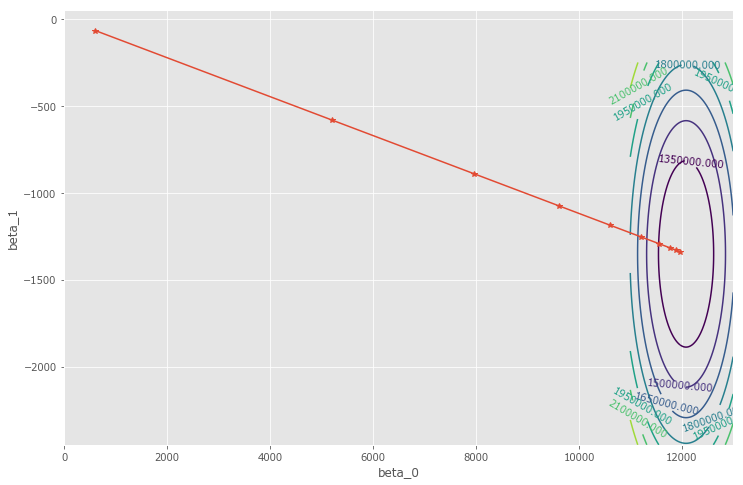

In [25]:
beta0 = np.linspace(11000 , 13000, 100)
beta1 = np.linspace(-2450, -250, 100)

B0, B1= np.meshgrid(beta0, beta1)

B_all = np.c_[B0.reshape(-1,1), B1.reshape(-1,1)].T

L = X_model.dot(B_all) - y_train.reshape(-1,1)
L = L ** 2
L = L.mean(axis=0)/2
L = L.reshape(B0.shape)

fig, ax = plt.subplots(1,1)
contour = ax.contour(B0, B1, L)
plt.clabel(contour, inline=1, fontsize=10)
ax.set_xlabel('beta_0')
ax.set_ylabel('beta_1')

betas = np.array(betas)
ax.plot(betas[:,0], betas[:,1], marker='*')


# Логистическая регрессия

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

## Игрушечный пример

Сгенерируем выборку и опробуем логистическую регрессию

In [27]:
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) + [2, 2],
          np.random.randn(20, 2) + [-2, -2]]
y = [-1] * 20 + [1] * 20

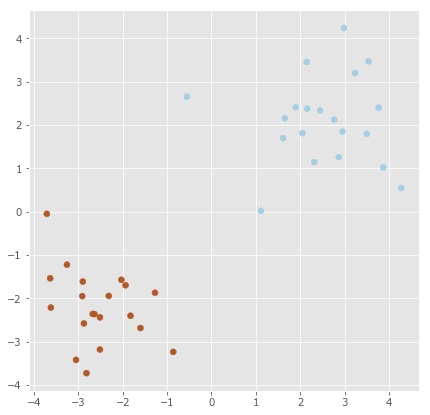

In [28]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[:, 0],
           X[:, 1],
           c=y,
           cmap=plt.cm.Paired)

In [29]:
from sklearn.linear_model import LogisticRegression

Обучим логистическую регрессию на этих данных и нарисуем разделяющую гиперплоскость

In [30]:
model = LogisticRegression(C=1.0, 
                           fit_intercept=True, 
                           penalty='l2')
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
print 'w_0 = %f' % model.intercept_
print 'w_1, w_2 = ', model.coef_[0]

w_0 = -0.183954
w_1, w_2 =  [-1.06097157 -1.00171289]


In [ ]:
# Нарисуем эту гиперплоскость


In [33]:
y_hat = model.predict(X)
y_hat[:10]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [34]:
y_hat_proba = model.predict_proba(X)
y_hat_proba[:10, :]

array([[  9.98616528e-01,   1.38347180e-03],
       [  9.99496019e-01,   5.03981209e-04],
       [  9.95091160e-01,   4.90883960e-03],
       [  9.94323473e-01,   5.67652674e-03],
       [  9.90157090e-01,   9.84290974e-03],
       [  9.97319087e-01,   2.68091305e-03],
       [  9.94720579e-01,   5.27942062e-03],
       [  9.94026880e-01,   5.97312006e-03],
       [  9.96628393e-01,   3.37160720e-03],
       [  9.77815343e-01,   2.21846572e-02]])

In [35]:
dec_func = model.decision_function(X)
dec_func[:10]

array([-6.58177471, -7.59246747, -5.31179677, -5.16572302, -4.61111223,
       -5.91891334, -5.23864551, -5.11449484, -5.68898843, -3.78591991])

### Как сделать нелинейную границу?

Рассмотрим набор данных, который в простонародье называют "Бублик".

In [36]:
from sklearn.datasets import make_circles

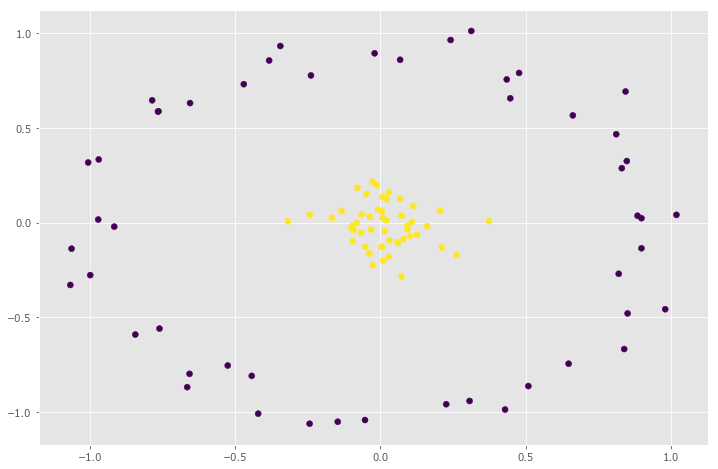

In [37]:
X, y = make_circles(n_samples=100, shuffle=True,
                    noise = 0.1,
                    factor=0.1)

plt.scatter(X[:, 0],
            X[:, 1],
            c=y)

Очевидно, что классы нельзя разделить линией. Но можно сделать это окружностью! </br>
Т.е. разделяющся линия теперь будет задаваться не уравнением прямой $g(x) = w_0 + w_1x_1 + w_2x_2$, а уравнением окружности. 

Выполните преобразование матрицы X, чтобы в ней были столбцы для $x_1$, $x_2$, $x^2_1$ + $x^2_2$ и обучите логистическую регрессию.

In [39]:
# Your code Here
X_new = np.c_[X, X[:,0]**2 + X[:,1]**2]
model = LogisticRegression(C=100000, 
                           fit_intercept=True)
model.fit(X_new, y)

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [40]:
X_new[:10]

array([[ 0.6628582 ,  0.566528  ,  0.76033498],
       [ 1.01976426,  0.04139   ,  1.04163229],
       [ 0.11345315,  0.08853271,  0.02070966],
       [-0.02778909,  0.21590001,  0.04738505],
       [ 0.09266786, -0.01594095,  0.00884145],
       [ 0.00524132, -0.12529629,  0.01572663],
       [ 0.4776595 ,  0.79054453,  0.85311925],
       [-0.24323304,  0.04272888,  0.06098807],
       [-0.2439184 , -1.06114425,  1.1855233 ],
       [ 0.89929878,  0.02373896,  0.80930184]])

In [41]:
# Посчитаем количество ошибок
y_hat = model.predict(X_new)
(y != y_hat).sum()

0

In [42]:
# Нарисуем полученную окружность

x0, x1 = np.meshgrid(np.arange(-1.5, 1.5, 0.1),
                       np.arange(-1.5, 1.5, 0.1))
xx0, xx1 = x0.ravel(), x1.ravel()

# Your code here

## Анализ тональности

Загрузите текстовые данные [отсюда](https://archive.ics.uci.edu/ml/machine-learning-databases/00331/). Архив должен содержать 3 файла с положительными и отрицательными отзывами с ресурсов
* imdb.com
* amazon.com
* yelp.com

Формат файла следующий:
<отзыв>\t<метка>\n


### Задача
1. Загрузите тексты и метки классов в разные переменные
2. Выберите меру качества классификации
3. Обучите логистическую (без подбора гиперпараметров). Тексты представляются в виде мешка слов
4. Выведите наиболее значимые слова из текста

In [ ]:
sent_data = pd.read_csv('sentiment/yelp_labelled.txt', sep='\t', names=['sentence', 'label'], header=None)

In [ ]:
sent_data.head()

In [ ]:
sent_data.shape

In [ ]:
X = sent_data.sentence.values
y = sent_data.label.values

In [ ]:
# Your Code Here

# Sberbank DS Contest

В этом задании мы рассмотрим данные с предыдущего Sberbank Data Science Contest. К сожалению найти страницу с конкурсом уже не получается.

Одной из задач была опредление пола владельца карты по его транзакциям на карте. Зачем это нужно - одному сберу известно, но эта задача была хороша тем, что в ней можно нагенерировать много разных признаков

Есть такая [презентация](https://alexanderdyakonov.files.wordpress.com/2016/10/dj2016_sdsj_vis.pdf) с предварительным анализом данных и идеями про признаки

Нам понадобятся файлы `customers_gender_train.csv`, `transactions.tsv.gz`, `mcc_types.tsv` и `trans_types.tsv`.

## Посмотрим на данные

Это метки ответов

In [ ]:
df_gender = pd.read_csv('data/customers_gender_train.csv')
df_gender.head()

Это сами транзакции (отрицательные транзакции - списывание, положительные - зачисление на счет)

In [ ]:
df_transactions = pd.read_csv('data/transactions.csv.gz')
df_transactions.head()

Далее, расшифровки кодов [mcc](https://ru.wikipedia.org/wiki/Merchant_Category_Code) и транзакций

In [ ]:
df_tr = pd.read_csv('data/tr_types.csv', sep=';', encoding='utf8')
df_tr.head()

In [ ]:
df_mcc = pd.read_csv('data/tr_mcc_codes.csv', sep=';', encoding='utf8')
df_mcc.head()

Первое что мы видем - это странная дата и суммы в транзакциях. 

В принципе, посмотрев на исходное распределение "относительных" дат по какой-нибудь гендерной группы mcc, становится примерно понятно, что за даты закодированы.

Ну а суммы транзакций организаторы просто умножили на $\pi^{\exp}$ =)

Преобразование будет проделано ниже, но при желании, можете сами со всем разобраться.

In [ ]:
from pandas import Timestamp, DateOffset

In [ ]:
def preproc_transactions(df_transactions):
    sec_per_day = 86400
    sec_per_hour = 3600
    
    start_date = 1420070400 - 154 * sec_per_day - 3 * sec_per_hour
    
    df_transactions.loc[:, 'day'] = df_transactions.tr_datetime\
                                               .str.split(' ')\
                                               .str.get(0)\
                                               .astype(int)
    df_transactions.loc[:, 'time_raw'] = df_transactions.tr_datetime\
                                                    .str.split(' ')\
                                                    .str.get(1)

    # set temp dt
    df_transactions.loc[:, 'dt_temp'] = pd.to_datetime(df_transactions.loc[:, 'time_raw'], 
                                                    format='%H:%M:%S')\
                                        + DateOffset(years=115)
    
    df_transactions = df_transactions.assign(dt = lambda x: x.dt_temp.astype(np.int64) // 10**9
                                             + (x.day - 153) * sec_per_day)\
                                     .assign(weekday = lambda x: ((x.day + 4) % 7 + 1))
        
    df_transactions.loc[:, 'datetime'] = pd.to_datetime(df_transactions.dt, unit='s')
    df_transactions.loc[:, 'date'] = df_transactions.loc[:, 'datetime'].dt.strftime('%Y-%m-%d')
    df_transactions.loc[:, 'hour'] = df_transactions.loc[:, 'datetime'].dt.strftime('%H')
    
    df_transactions = df_transactions.drop(['dt_temp', 'time_raw', 'tr_datetime'], axis=1)
    
    df_transactions.loc[:, 'amount'] = np.round(df_transactions.loc[:, 'amount']/(np.pi**np.exp(1)))
            
    return df_transactions

In [ ]:
df_transactions = df_transactions.pipe(preproc_transactions)

## Генерим признаки

* Для котого мы делаем предсказания?
* Какие признаки этих объектов мы можем рассчитать?

In [ ]:
def gen_features(df_gender, df_transactions):
        
    return df_features

In [ ]:
df_features = df_gender.pipe(gen_features, df_transactions)

In [18]:
X = df_features.loc[:, idx_features].values
y = df_features.loc[:, ~idx_features].values.flatten()

## Подбор гипер-параметров

### Pipeline

Сделаем простой sklearn пайплайн, который делает следующее:
* Нормирует признаки через StandartScaler
* Запускает лог-регрессию

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression

In [ ]:
model = Pipeline([
    ...
])

In [ ]:
RND_SEED = 123

До этого мы исключительно смотрели, как влияет на меру качества какой-то один параметр при фиксированных остальных. Пришло время перебирать все что можно!

В базовом варианте, это делается либо через `Grid Search`, либо через `Random Search`. Какие ключевые отличия?
* В `Grid Search` вы в явнов виде задаете возможные значения каждого гипер-параметра, который хотите варьировать. Соответственно, выполняется **полный** перебор всех возможных комбинаций
* В `Random Search` допукается указание распределения параметров, например "равномерно, на интервале от 0 до 100" или "нормальное распределение с таким-то цетром и такой-то дисперсией. Соответственно, так как это случайный перебор, то **вы** просто **задаете** количество случайных комбинаций, которые будут проверяться

Может показаться, что делать случайный перебор опасно - там же все случайно. Но на практике именно он и искользуется в силу двух причин
* Полный перебор большого количества комбинаций очень долгий
* Мы можем просто пропустить значения гиперпараметра, которые сильно влияют на метрику качества (см рисунок снизу)

<img src='images/gridsearch.jpeg'>

In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=RND_SEED, shuffle=True)

In [ ]:
param_grid = {
    'scaler__with_mean': [False, True],
    'clf__penalty': ['l2'],
    'clf__random_state': [RND_SEED],
    'clf__C': sp_lognorm(4)
}

random_searcher = RandomizedSearchCV(model, param_grid, n_iter=100, 
                                     random_state=RND_SEED,
                                     scoring='roc_auc', 
                                     n_jobs=-1, cv=cv, 
                                     verbose=2)

random_searcher.fit(X, y)